# Setup

In [2]:
import pandas as pd
import polars as pl 
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from all import NLP_Preprocessing

from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfVectorizer)
from sklearn.preprocessing import (LabelEncoder,
                                   OneHotEncoder)
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (confusion_matrix)

from tensorflow import keras
from keras import layers

In [3]:
tools = NLP_Preprocessing()

In [4]:
data = pl.read_csv("./dataset.csv")

In [5]:
data.head()

app_id,app_name,review_text,review_score,review_votes
i64,str,str,i64,i64
10,"""Counter-Strike""","""Ruined my life.""",1,0
10,"""Counter-Strike""","""This will be more of a ''my ex…",1,1
10,"""Counter-Strike""","""This game saved my virginity.""",1,0
10,"""Counter-Strike""","""• Do you like original games? …",1,0
10,"""Counter-Strike""",""" Easy to learn, hard to…",1,1


In [6]:
data.shape

(6417106, 5)

In [7]:
data["review_score"].value_counts()["review_score"]

review_score
i64
-1
1


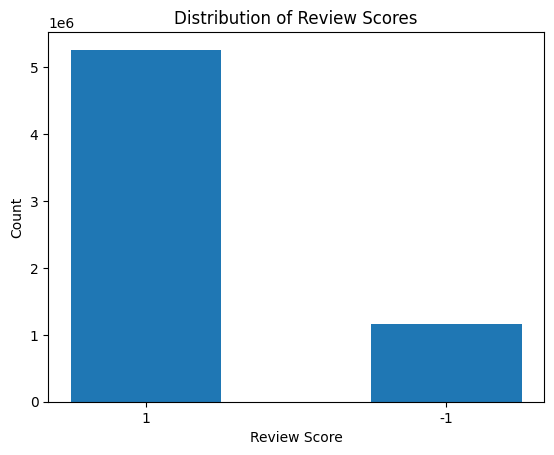

In [8]:
value_counts = data["review_score"].value_counts()
cols = value_counts["review_score"].to_numpy().astype(str)
counts = value_counts["count"].to_numpy() 

plt.bar(cols, counts, width=0.5)
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.title("Distribution of Review Scores")
plt.show()

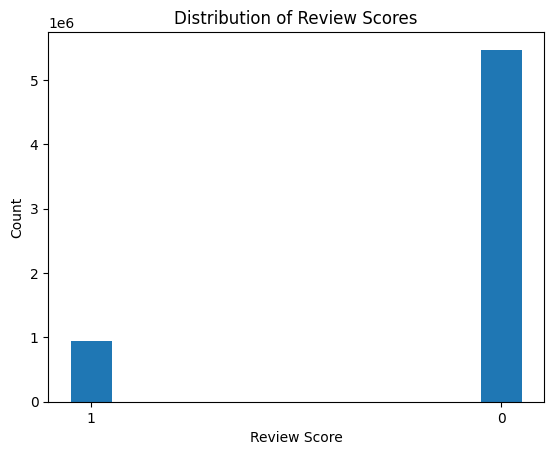

In [9]:
value_counts = data["review_votes"].value_counts()
cols = value_counts["review_votes"].to_numpy().astype(str)
counts = value_counts["count"].to_numpy() 

plt.bar(cols, counts, width=0.1)
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.title("Distribution of Review Scores")
plt.show()

# Tiền xử lý dữ liệu

In [10]:
data.null_count()

app_id,app_name,review_text,review_score,review_votes
u32,u32,u32,u32,u32
0,183234,7305,0,0


In [11]:
data.null_count()*100/len(data)

app_id,app_name,review_text,review_score,review_votes
f64,f64,f64,f64,f64
0.0,2.855399,0.113836,0.0,0.0


In [12]:
data["review_text"].null_count()/len(data)

0.0011383636174936177

In [13]:
data = data[:, ["review_text", "review_votes"]]

In [14]:
data = data.drop_nulls()

In [15]:
data.null_count()*100/len(data)

review_text,review_votes
f64,f64
0.0,0.0


In [16]:
data = data.unique()

In [17]:
data.shape

(4483987, 2)

# Chọn dữ liệu nhỏ hơn

In [18]:
n_sample = 50

In [19]:
# Tron du lieu dam bao tinh ngau nhien
shuffled_data = data.sample(fraction=1, shuffle=True, seed=42)

In [20]:
# Lay n phan tu cua tieu cuc
votes_0 = shuffled_data.filter(pl.col("review_votes") == 0)
votes_0 = votes_0.head(n_sample)
votes_0.head()

review_text,review_votes
str,i64
"""The pinnacle of gaming. Truly …",0
"""the game is amazing. best part…",0
"""'This is RuptureFarms. They sa…",0
"""A cute 2 minutes game nothing …",0
"""hate it i just hate it ever ru…",0


In [21]:
votes_1 = shuffled_data.filter(pl.col("review_votes") == 1)
votes_1 = votes_1.head(n_sample)
votes_1.head()

review_text,review_votes
str,i64
"""Earth 2150 is an old 3D Real-T…",1
"""Very cool, but I dont play too…",1
"""I just got done fighting Credo…",1
"""DEVELOPER HAS STOPPED SUPPORTI…",1
"""GET THIS GAME ITS SO AWESOME B…",1


In [22]:
small_data = pl.concat([votes_0, votes_1])
print(small_data["review_votes"].unique())
small_data.shape

shape: (2,)
Series: 'review_votes' [i64]
[
	0
	1
]


(100, 2)

In [23]:
docs = small_data["review_text"]
labels = small_data["review_votes"]

In [24]:
tokens = tools.preprocess(docs)
docs = tools.get_corpus(tokens)

In [25]:
print(tokens[0])
print(docs[0])

['pinnacl', 'game', 'truli', 'mirror', 'modern', 'day', 'struggl', 'rat', 'face']
pinnacl game truli mirror modern day struggl rat face


# TF-IDF

In [26]:
X = docs
y = labels.to_numpy()

In [27]:
tfidf_vectorizer = TfidfVectorizer(norm="l2")
X = tfidf_vectorizer.fit_transform(X)
X.shape

(100, 1129)

In [28]:
X = X.toarray()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)

<Axes: >

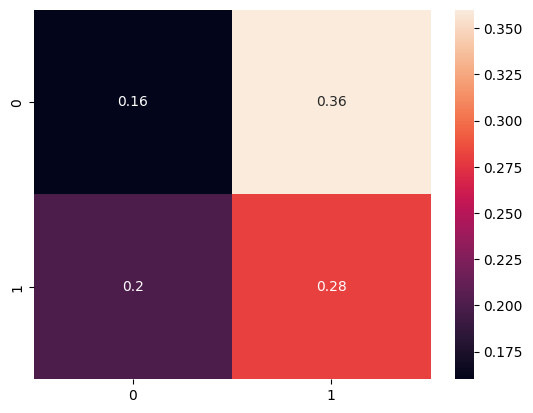

In [30]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
nb_cfs_mtx = confusion_matrix(y_test, y_pred)

sns.heatmap(nb_cfs_mtx/np.sum(nb_cfs_mtx), annot=True)

# Word Embedding

## One-hot encoding

In [31]:
flat_tokens = [token for sublist in tokens for token in sublist]
print(len(flat_tokens))


3130


In [32]:
le = LabelEncoder()
le.fit(flat_tokens)

LabelEncoder()

In [33]:
print('Class of words: ', le.classes_)
lbl_encoded = le.transform(flat_tokens)
print(lbl_encoded)
print(le.inverse_transform(lbl_encoded))

Class of words:  ['abe' 'abil' 'abl' ... 'zero' 'zombi' 'zone']
[ 751  432 1039 ...  545 1028  624]
['pinnacl' 'game' 'truli' ... 'interest' 'traffic' 'manag']


In [34]:

oh = OneHotEncoder()
classes_indices = list(zip(le.classes_, np.arange(len(le.classes_))))
print('Classes_indices: ', classes_indices)
oh.fit(classes_indices)
print('One-hot categories and indices:', oh.categories_)
# Biến đổi list words sang dạng one-hot
words_indices = list(zip(flat_tokens, lbl_encoded))
print('Words and corresponding indices: ', words_indices)
one_hot = oh.transform(words_indices).toarray()
print('Transform words into one-hot matrices: \n', one_hot)
print('Inverse transform to categories from one-hot matrices: \n', oh.inverse_transform(one_hot))


Classes_indices:  [(np.str_('abe'), np.int64(0)), (np.str_('abil'), np.int64(1)), (np.str_('abl'), np.int64(2)), (np.str_('absolut'), np.int64(3)), (np.str_('abund'), np.int64(4)), (np.str_('accur'), np.int64(5)), (np.str_('achiev'), np.int64(6)), (np.str_('across'), np.int64(7)), (np.str_('act'), np.int64(8)), (np.str_('action'), np.int64(9)), (np.str_('activ'), np.int64(10)), (np.str_('actual'), np.int64(11)), (np.str_('add'), np.int64(12)), (np.str_('addict'), np.int64(13)), (np.str_('adjust'), np.int64(14)), (np.str_('admit'), np.int64(15)), (np.str_('advanc'), np.int64(16)), (np.str_('advertis'), np.int64(17)), (np.str_('affect'), np.int64(18)), (np.str_('afraid'), np.int64(19)), (np.str_('ago'), np.int64(20)), (np.str_('agre'), np.int64(21)), (np.str_('ahead'), np.int64(22)), (np.str_('ai'), np.int64(23)), (np.str_('aliv'), np.int64(24)), (np.str_('alli'), np.int64(25)), (np.str_('allow'), np.int64(26)), (np.str_('almost'), np.int64(27)), (np.str_('alreadi'), np.int64(28)), (np.s

In [35]:
print(one_hot.shape)

(3130, 2264)


## Auto Encoder

In [36]:
print(*le.classes_)

abe abil abl absolut abund accur achiev across act action activ actual add addict adjust admit advanc advertis affect afraid ago agre ahead ai aliv alli allow almost alreadi also alter alway amaz amd america amount amp annoy anoth answer anybodi anymor anyon anyth anyway apart appar appeal appli approxim arbitrari area arm armi armor around art artist asf aspect assassin assembl atmospher attach attack attempt attitud audienc automat avail avid avoid award awesom awhil awkward back background backyard bad badg badli bag ball bare base basi basic battl beast beat beauti becom beef begin behind believ benefit best beta better big biggest bit bla block blockbust blow blue blueprint board bonu bonus book boost bore boss bother bottom bought bounc bound box brace branch brand break breaker bridg bring broadcast brought bu buddi budget bug build built bundl burn busi button buy bye call calm came campaign cant captain captur car card career careless carri casual cat caus cave censorship cent

In [37]:
class AutoEncoder(layers.Layer):

    def __init__(self, in_units, hidden_units):
        super().__init__()
        self.dense1 = layers.Dense(in_units, activation="relu")
        self.dense2 = layers.Dense(hidden_units, activation="relu")
        self.dense3 = layers.Dense(in_units, activation="softmax")

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)

        return x

In [38]:
inputs = layers.Input(shape=(one_hot.shape[1],))
autoencoder_layer = AutoEncoder(one_hot.shape[1], one_hot.shape[1]//2)
outputs = autoencoder_layer(inputs)

model = keras.Model(inputs=inputs, outputs=outputs)

In [39]:
model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.SGD())

In [40]:
model.fit(one_hot, one_hot, epochs=5, batch_size=32)

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 15.4471
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 15.4244
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 15.4046
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 15.3762
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 15.3594


In [41]:
query_word = "zombi"

# Get the index for "game" using the LabelEncoder
query_index = le.transform([query_word])[0]  # Get the encoded index for "game"
query = [[query_word, query_index]]  # Create the (word, index) pair

# Transform the query into one-hot encoding
query_one_hot = oh.transform(query).toarray()

print("Query one-hot encoded:\n", query_one_hot)

Query one-hot encoded:
 [[0. 0. 0. ... 0. 1. 0.]]


## Search

In [42]:
query = "zombie"
query = tools.preprocess([query])
print(query)

[['zombi']]
